# Figure 3
 - Explained variance each subject individually
 

In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from subjects import sd,nsd,sd_colors,figpath_sd
from neuropy.analyses import ExplainedVariance
from neuropy import plotting

sd_sessions = sd.ratNday1 + sd.ratSday3  + sd.ratUday4
nsd_sessions = nsd.ratNday2 + nsd.ratSday2 + nsd.ratUday2

In [2]:
sd_expvar, nsd_expvar = [], []
for grp, sessions in enumerate([sd_sessions, nsd_sessions]):
    for sub, sess in enumerate(sessions):
        pre = sess.paradigm["pre"]
        maze = sess.paradigm["maze"]
        if maze.size ==0:
            maze = sess.paradigm["maze1"]
        post = sess.paradigm["post"]

        re_maze = sess.paradigm['re-maze']
        if re_maze.size !=0:
            post = [post[0],re_maze[1]]

        neurons = sess.neurons.get_neuron_type("pyr")
        expvar = ExplainedVariance(
            neurons=neurons, template=maze, matching=post, control=pre
        )
        if grp == 0:
            sd_expvar.append(expvar)
        else:
            nsd_expvar.append(expvar)


/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


## Plotting

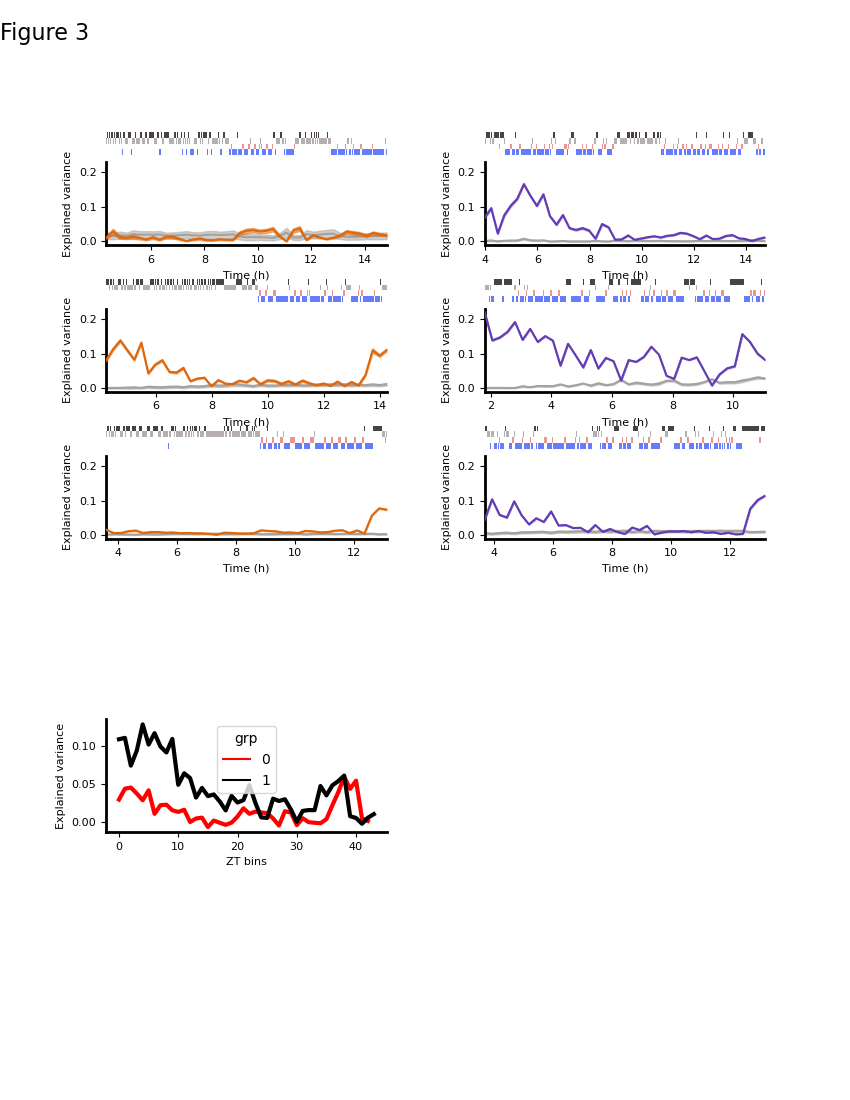

In [3]:
%matplotlib widget
import seaborn as sns
import numpy as np

figure = plotting.Fig()
fig, gs = figure.draw(num=1, grid=(6, 2), hspace=0.3, wspace=0.35)
# fig, axes = plt.subplots(6,2)
fig.suptitle("Figure 3", x=0, ha="left", fontsize=16)

sessions = [sd_sessions, nsd_sessions]
for grp_i, (expvar_grp, grp) in enumerate(zip([sd_expvar, nsd_expvar], ["sd", "nsd"])):
    grp_sessions = sessions[grp_i]
    for i, expvar in enumerate(expvar_grp):
        gs_ev = figure.subplot2grid(gs[i, grp_i], grid=(4, 1))
        ax = plt.subplot(gs_ev[1:])
        expvar.colors["ev"] = sd_colors[grp]
        expvar.colors["rev"] = "#a5a19c"
        expvar.plot(ax=ax, legend=None)
        ax.set_ylim([-0.01, 0.23])

        # ax_slp = ax.twinx()
        post = grp_sessions[i].paradigm['post']
        post_brainstates = grp_sessions[i].brainstates.time_slice(post[0],post[1])
        ax_hypno = plt.subplot(gs_ev[0])
        plotting.plot_hypnogram(post_brainstates, ax=ax_hypno)
        # ax_hypno.set_xlim(left=0)

df = pd.DataFrame()
for grp, expvars in enumerate([sd_expvar, nsd_expvar]):
    for i, expvar in enumerate(expvars):
        ev_diff = expvar.ev - expvar.rev
        ev_bins = np.arange(len(ev_diff))
        df = df.append(
            pd.DataFrame({"ev_diff": ev_diff, "bins": ev_bins, "grp": grp}),
            ignore_index=True,
        )

ax = plt.subplot(gs[4, 0])
sns.lineplot(
    data=df,
    x="bins",
    y="ev_diff",
    hue="grp",
    ci=None,
    ax=ax,
    linewidth=3,
    palette=["r", "k"],
)
ax.set_ylabel("Explained variance")
ax.set_xlabel("ZT bins")

figure.savefig(figpath_sd / "figure3")
